In this tutorial, we show how to use RipsNet to learn the topology of very simple synthetic data sets comprised of (noisy) circles. Let's first define the seed (for reproducibility), the number of point clouds that we will use for training RipsNet, the number of point clouds we will use to test it, the cardinality of the point clouds and finally the amount of corrupted points (when noise is added).

In [45]:
N_sets_train = 900  # Number of train point clouds
N_sets_test  = 300  # Number of test  point clouds
N_points     = 600  # Point cloud cardinality
N_noise      = 200  # Number of corrupted points

Next we use helper functions to compute these point clouds.

In [46]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [47]:
%pip install gudhi tqdm

Note: you may need to restart the kernel to use updated packages.


In [48]:
from datasets.utils import create_multiple_circles

In [49]:
data_train,      label_train       = create_multiple_circles(N_sets_train, N_points, noisy=0, N_noise=N_noise)
clean_data_test, clean_label_test  = create_multiple_circles(N_sets_test,  N_points, noisy=0, N_noise=N_noise)
noisy_data_test, noisy_label_test  = create_multiple_circles(N_sets_test,  N_points, noisy=1, N_noise=N_noise)

 40%|███▉      | 119/300 [00:00<00:00, 303.21it/s]

100%|██████████| 100/100 [00:00<00:00, 132.60it/s]


Let's check some of these point clouds!

In [50]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

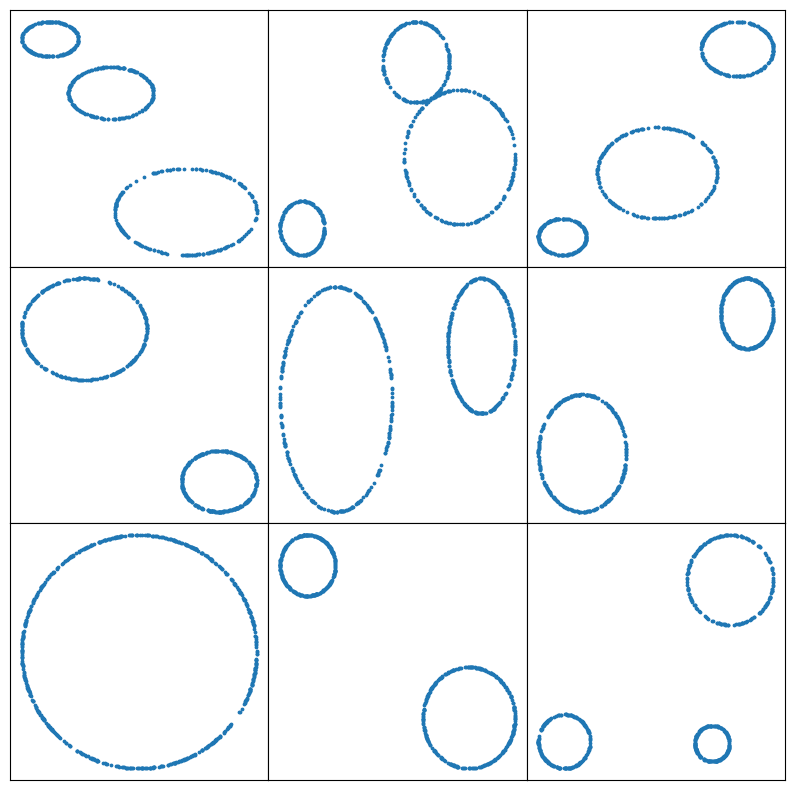

In [51]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(clean_data_test[3*i+j][:,0], clean_data_test[3*i+j][:,1], s=3)
        plt.xticks([])
        plt.yticks([])
plt.savefig('clean_gudhi_pc.png', bbox_inches='tight')

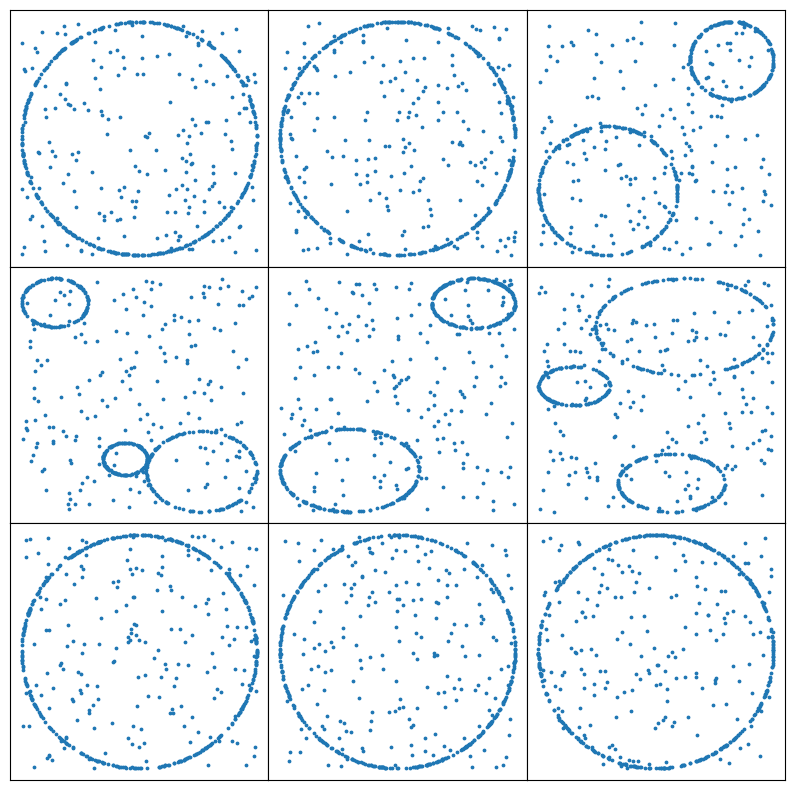

In [52]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(noisy_data_test[3*i+j][:,0], noisy_data_test[3*i+j][:,1], s=3)
        plt.xticks([])
        plt.yticks([])
plt.savefig('noisy_gudhi_pc.png', bbox_inches='tight')

As one can see, they contain 1 to 3 circular shapes. We will use these circle numbers later for checking the accuracy of the topology computed by RipsNet. For now, let's save them as proper labels.

In [53]:
from sklearn.preprocessing import LabelEncoder

In [54]:
le = LabelEncoder().fit(label_train)
label_classif_train = le.transform(label_train)
clean_label_classif_test  = le.transform(clean_label_test)
noisy_label_classif_test  = le.transform(noisy_label_test)

In order to train RipsNet, we need the correct topology on the train data. So let's compute it with [Gudhi](https://gudhi.inria.fr/python/latest/). The topology of point clouds can be inferred from several filtrations, so we will use a fast and sparse one (in 2D), namely the [Alpha filtration](https://gudhi.inria.fr/python/latest/alpha_complex_user.html). First, we need to get a sense of the maximal filtration value to use, which we will approximate with the largest pairwise distance of the first 30 point clouds.

In [55]:
import numpy as np
from sklearn.metrics import pairwise_distances

In [56]:
ds = [pairwise_distances(X).flatten() for X in data_train[:30]]
maxd = np.max(np.concatenate(ds))

Now, we can compute the persistence diagrams (in homology dimension 1) of the train, clean test and noisy test point clouds!

In [57]:
from tqdm import tqdm 

In [58]:
import gudhi as gd

In [59]:
PD_train = []
for X in tqdm(data_train):
    st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    PD_train.append(dg)

100%|██████████| 900/900 [00:13<00:00, 66.18it/s]


In [60]:
clean_PD_test = []
for X in tqdm(clean_data_test):
    st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    clean_PD_test.append(dg)

100%|██████████| 300/300 [00:04<00:00, 68.63it/s]


In [61]:
noisy_PD_test = []
for X in tqdm(noisy_data_test):
    st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    noisy_PD_test.append(dg)

100%|██████████| 300/300 [00:03<00:00, 82.21it/s] 


RipsNet actually works on vectorizations of persistence diagrams (PDs), so we will try two: the [persistence image](https://jmlr.org/papers/volume18/16-337/16-337.pdf), and the [persistence landscape](https://jmlr.csail.mit.edu/papers/volume16/bubenik15a/bubenik15a.pdf). First, let's filter out any PD point with infinite coordinates.

In [62]:
from gudhi.representations import DiagramSelector

In [63]:
PVs_train, clean_PVs_test, noisy_PVs_test, PVs_params = [], [], [], []
pds_train      = DiagramSelector(use=True).fit_transform(PD_train)
clean_pds_test = DiagramSelector(use=True).fit_transform(clean_PD_test)
noisy_pds_test = DiagramSelector(use=True).fit_transform(noisy_PD_test)

Fortunately, Gudhi also has code for computing vectorizations!! However, before launching the computations, we have to estimate a few parameters: the image bandwidth (taken as the 20% quantile of the positive birth-persistence-transformed-PD pairwise distances),
and the image and landscape limits (taken as the min and max of birth-persistence-transformed-PD point coordinates). 

In [64]:
vpdtr = np.vstack(pds_train)
pers = vpdtr[:,1]-vpdtr[:,0]
bps_pairs = pairwise_distances(np.hstack([vpdtr[:,0:1],vpdtr[:,1:2]-vpdtr[:,0:1]])[:200]).flatten()
ppers = bps_pairs[np.argwhere(bps_pairs > 1e-5).ravel()]
sigma = np.quantile(ppers, .2)
im_bnds = [np.quantile(vpdtr[:,0],0.), np.quantile(vpdtr[:,0],1.), np.quantile(pers,0.), np.quantile(pers,1.)]
sp_bnds = [np.quantile(vpdtr[:,0],0.), np.quantile(vpdtr[:,1],1.)]

We can now compute and normalize the vectorizations (this can help RipsNet training)!

In [65]:
from gudhi.representations import Landscape, PersistenceImage

In [66]:
import numpy as np
import torch

if 'im_bnds' not in locals() or im_bnds is None:
    all_points = np.concatenate(pds_train, axis=0)
    x_min, x_max = np.min(all_points[:, 0]), np.max(all_points[:, 0])
    y_min, y_max = np.min(all_points[:, 1]), np.max(all_points[:, 1])
    im_bnds = [x_min, x_max, y_min, y_max]

PI_params = {
    'bandwidth': sigma,
    'weight': lambda x: 10 * np.tanh(x[1]),
    'resolution': [50, 50],
    'im_range': im_bnds
}

PI = PersistenceImage(**PI_params)
PI.fit(pds_train)  

PI_train = PI.transform(pds_train)
clean_PI_test = PI.transform(clean_pds_test)
noisy_PI_test = PI.transform(noisy_pds_test)

MPI = np.max(PI_train)
if MPI == 0 or np.isnan(MPI):
    raise ValueError("MPI (max value) is zero or NaN; check persistence diagrams.")
else:
    PI_train /= MPI
    clean_PI_test /= MPI
    noisy_PI_test /= MPI

PI_train = torch.tensor(PI_train, dtype=torch.float32)
clean_PI_test = torch.tensor(clean_PI_test, dtype=torch.float32)
noisy_PI_test = torch.tensor(noisy_PI_test, dtype=torch.float32)

print(f"PI_train shape: {PI_train.shape}")
print(f"clean_PI_test shape: {clean_PI_test.shape}")
print(f"noisy_PI_test shape: {noisy_PI_test.shape}")
print(f"Max pixel intensity (MPI): {MPI:.5f}")


PI_train shape: torch.Size([900, 2500])
clean_PI_test shape: torch.Size([300, 2500])
noisy_PI_test shape: torch.Size([300, 2500])
Max pixel intensity (MPI): 0.13987


In [67]:

if 'sp_bnds' not in locals() or sp_bnds is None:
    all_points = np.concatenate(pds_train, axis=0)
    x_min, x_max = np.min(all_points[:, 0]), np.max(all_points[:, 1])
    sp_bnds = [x_min, x_max]


PL_params = {
    'num_landscapes': 5,
    'resolution': 300,
    'sample_range': sp_bnds
}

PL = Landscape(**PL_params)
PL.fit(pds_train) 

PL_train = PL.transform(pds_train)
clean_PL_test = PL.transform(clean_pds_test)
noisy_PL_test = PL.transform(noisy_pds_test)

MPL = np.max(PL_train)
if MPL == 0 or np.isnan(MPL):
    raise ValueError("MPL (max landscape value) is zero or NaN; check your persistence diagrams.")
else:
    PL_train /= MPL
    clean_PL_test /= MPL
    noisy_PL_test /= MPL

PL_train = torch.tensor(PL_train, dtype=torch.float32)
clean_PL_test = torch.tensor(clean_PL_test, dtype=torch.float32)
noisy_PL_test = torch.tensor(noisy_PL_test, dtype=torch.float32)

print(f"PL_train shape: {PL_train.shape}")
print(f"clean_PL_test shape: {clean_PL_test.shape}")
print(f"noisy_PL_test shape: {noisy_PL_test.shape}")
print(f"Max landscape value (MPL): {MPL:.5f}")


PL_train shape: torch.Size([900, 1500])
clean_PL_test shape: torch.Size([300, 1500])
noisy_PL_test shape: torch.Size([300, 1500])
Max landscape value (MPL): 17.61831


It is finally time to train RipsNet! We will do it with TensorFlow, and custom DeepSet operations.

In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from utils import DenseRagged, PermopRagged

First, let's convert the point clouds into ragged tensors.

In [69]:
tf_data_train = [torch.tensor(pc, dtype=torch.float32) for pc in data_train]
tf_clean_data_test = [torch.tensor(pc, dtype=torch.float32) for pc in clean_data_test]
tf_noisy_data_test = [torch.tensor(pc, dtype=torch.float32) for pc in noisy_data_test]

Next, we define our RipsNet architecture for learning persistence images, a sequence of fully-connected DeepSet layers, with ReLu activations, Adamax optimizer, and early stopping.

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adamax

class DenseRagged(nn.Module):
    def __init__(self, in_features=None, out_features=30, activation='relu', use_bias=True):
        super(DenseRagged, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias
        self.activation = activation

        self.weight = None
        self.bias = None

    def forward(self, inputs):
        outputs = []
        for x in inputs:
            if self.weight is None:
                in_features = x.shape[-1]
                self.weight = nn.Parameter(torch.randn(in_features, self.out_features) * 0.01)
                if self.use_bias:
                    self.bias = nn.Parameter(torch.zeros(self.out_features))
            y = torch.matmul(x, self.weight)
            if self.use_bias:
                y = y + self.bias
            if self.activation == 'relu':
                y = F.relu(y)
            elif self.activation == 'sigmoid':
                y = torch.sigmoid(y)
            elif self.activation == 'tanh':
                y = torch.tanh(y)
            outputs.append(y)
        return outputs


class PermopRagged(nn.Module):
    def forward(self, inputs):
        return torch.stack([torch.sum(x, dim=0) for x in inputs])


class RaggedPersistenceModel(nn.Module):
    def __init__(self, output_dim):
        super(RaggedPersistenceModel, self).__init__()
        self.ragged_layers = nn.ModuleList([
            DenseRagged(out_features=30, activation='relu'),
            DenseRagged(out_features=20, activation='relu'),
            DenseRagged(out_features=10, activation='relu')
        ])
        self.perm = PermopRagged()

        self.fc = nn.Sequential(
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, 200),
            nn.ReLU(),
            nn.Linear(200, output_dim),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        x = inputs
        for layer in self.ragged_layers:
            x = layer(x)
        x = self.perm(x)
        x = self.fc(x)
        return x


output_dim = PI_train.shape[1] 
model_PI = RaggedPersistenceModel(output_dim=output_dim)

optimizer = Adamax(model_PI.parameters(), lr=5e-4)
criterion = nn.MSELoss()


Time to learn!

In [ ]:
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_PI = model_PI.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adamax(model_PI.parameters(), lr=5e-4)

patience = 200
best_val_loss = float('inf')
patience_counter = 0
num_epochs = 10000

train_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_data_train]
train_targets = torch.tensor(PI_train, dtype=torch.float32).to(device)

val_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_clean_data_test]
val_targets = torch.tensor(clean_PI_test, dtype=torch.float32).to(device)

history = {'train_loss': [], 'val_loss': []}

for epoch in range(num_epochs):
    model_PI.train()
    optimizer.zero_grad()

    outputs = model_PI(train_inputs)
    loss = criterion(outputs, train_targets)
    loss.backward()
    optimizer.step()

    model_PI.eval()
    with torch.no_grad():
        val_outputs = model_PI(val_inputs)
        val_loss = criterion(val_outputs, val_targets)

    history['train_loss'].append(loss.item())
    history['val_loss'].append(val_loss.item())

    if val_loss.item() < best_val_loss - 1e-5:
        best_val_loss = val_loss.item()
        patience_counter = 0
        best_model_state = model_PI.state_dict()
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {loss.item():.6f}, Val loss: {val_loss.item():.6f}")

model_PI.load_state_dict(best_model_state)
print(f"Training complete. Best val_loss = {best_val_loss:.6f}")


/tmp/ipykernel_37538/2503157255.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_data_train]
/tmp/ipykernel_37538/2503157255.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_targets = torch.tensor(PI_train, dtype=torch.float32).to(device)
/tmp/ipykernel_37538/2503157255.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_clean_data_test]
/tmp/ipykernel_37538/2503157255.py:18: 

Epoch 50/10000 - Train loss: 0.116791, Val loss: 0.112774
Epoch 100/10000 - Train loss: 0.008212, Val loss: 0.007956
Epoch 150/10000 - Train loss: 0.004862, Val loss: 0.004860
Epoch 200/10000 - Train loss: 0.004293, Val loss: 0.004325
Epoch 250/10000 - Train loss: 0.004085, Val loss: 0.004133
Epoch 300/10000 - Train loss: 0.004001, Val loss: 0.004058
Epoch 350/10000 - Train loss: 0.003961, Val loss: 0.004022
Epoch 400/10000 - Train loss: 0.003936, Val loss: 0.004001
Epoch 450/10000 - Train loss: 0.003918, Val loss: 0.003984
Epoch 500/10000 - Train loss: 0.003899, Val loss: 0.003966
Epoch 550/10000 - Train loss: 0.003872, Val loss: 0.003940
Epoch 600/10000 - Train loss: 0.003837, Val loss: 0.003905
Epoch 650/10000 - Train loss: 0.003787, Val loss: 0.003855
Epoch 700/10000 - Train loss: 0.003714, Val loss: 0.003781
Epoch 750/10000 - Train loss: 0.003597, Val loss: 0.003664
Epoch 800/10000 - Train loss: 0.003421, Val loss: 0.003487
Epoch 850/10000 - Train loss: 0.003207, Val loss: 0.00327

Learning is done! The advantage of RipsNet is that we can now use it to predict persistence images directly from point clouds in the blink of an eye!

In [ ]:
model_PI.eval()

with torch.no_grad():
    train_inputs = [torch.tensor(x, dtype=torch.float64).to(device) for x in tf_data_train]
    clean_inputs = [torch.tensor(x, dtype=torch.float64).to(device) for x in tf_clean_data_test]
    noisy_inputs = [torch.tensor(x, dtype=torch.float64).to(device) for x in tf_noisy_data_test]

    train_PI_prediction = model_PI(train_inputs).cpu().numpy()
    clean_PI_prediction = model_PI(clean_inputs).cpu().numpy()
    noisy_PI_prediction = model_PI(noisy_inputs).cpu().numpy()

print("Predictions computed:")
print(f"train_PI_prediction shape: {train_PI_prediction.shape}")
print(f"clean_PI_prediction shape: {clean_PI_prediction.shape}")
print(f"noisy_PI_prediction shape: {noisy_PI_prediction.shape}")


/tmp/ipykernel_37538/1503333150.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_data_train]
/tmp/ipykernel_37538/1503333150.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clean_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_clean_data_test]
/tmp/ipykernel_37538/1503333150.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_noisy_data_test]


Predictions computed:
train_PI_prediction shape: (900, 2500)
clean_PI_prediction shape: (300, 2500)
noisy_PI_prediction shape: (300, 2500)


Let's see how accurate the predictions of RipsNet really are, at least on the train set.

Saved clean_gudhi_pc.png


/tmp/ipykernel_37538/2308465872.py:38: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  arr = np.array(clean_PI_test[idx])


Saved clean_gudhi_pi.png
Saved clean_ripsnet_pi.png


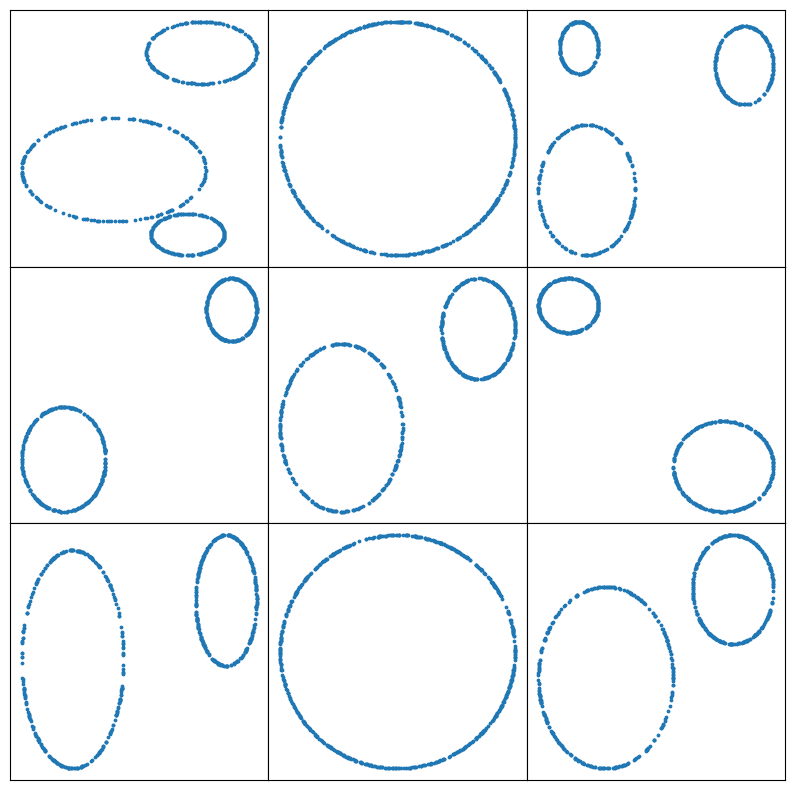

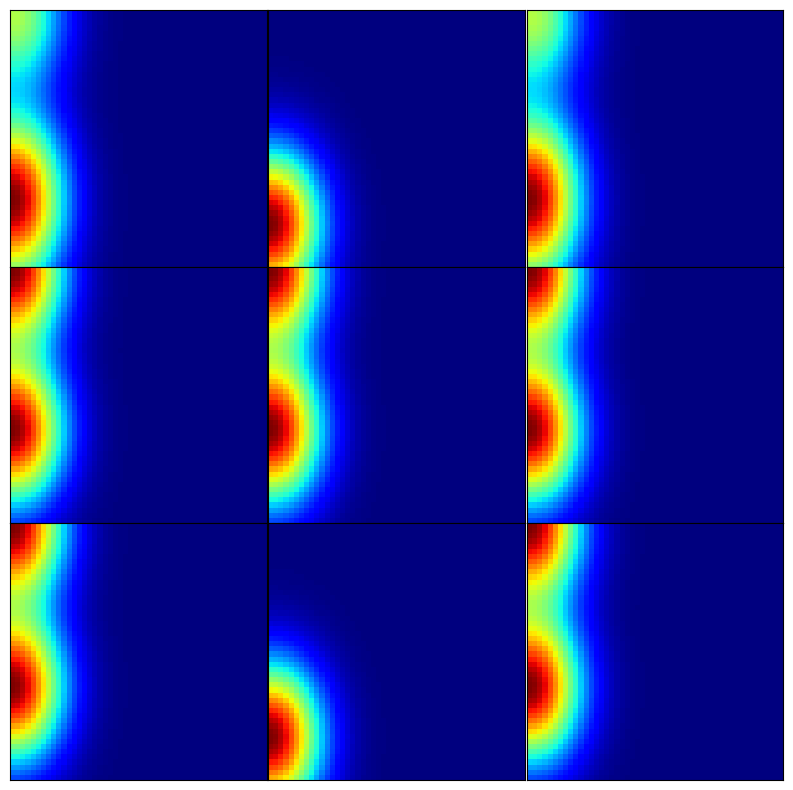

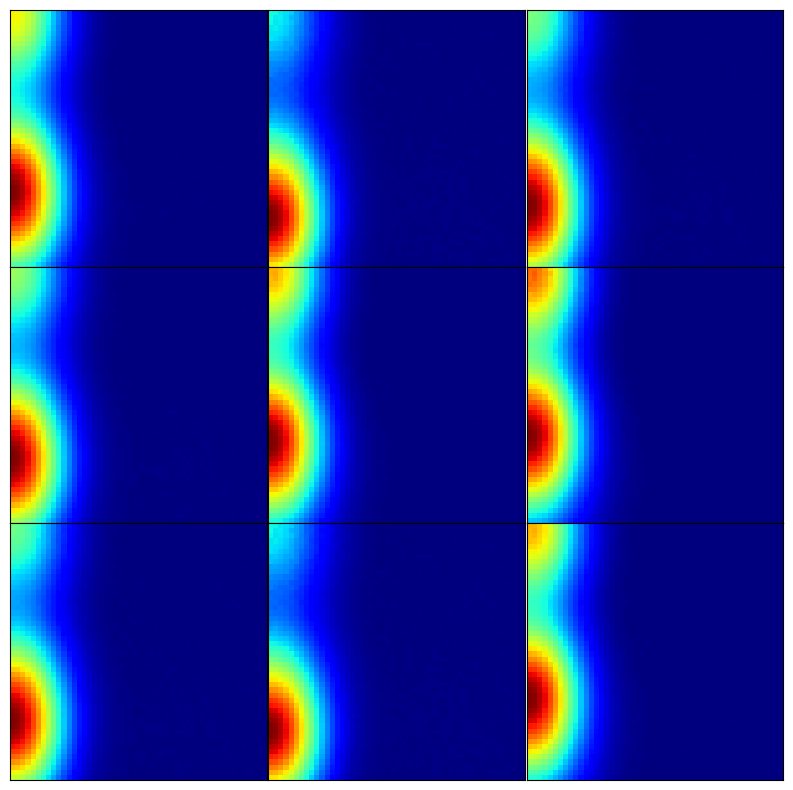

In [ ]:
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.array(x)

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])
        
        try:
            data = to_numpy(tf_clean_data_test[idx])
            if data.shape[1] != 2:
                print(f"Skipping idx={idx}, unexpected shape: {data.shape}")
                continue
            ax.scatter(data[:, 0], data[:, 1], s=3)
        except Exception as e:
            print(f"Error at idx={idx} in point cloud: {e}")
            continue
        
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig('clean_gudhi_pc.png', bbox_inches='tight')
print("Saved clean_gudhi_pc.png")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])
        
        arr = np.array(clean_PI_test[idx])
        if arr.size != 50*50:
            print(f"Skipping idx={idx}, unexpected size: {arr.size}")
            continue
        
        im = np.flip(arr.reshape(50, 50), 0)  # vertical flip
        ax.imshow(im, cmap='jet')
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig('clean_gudhi_pi.png', bbox_inches='tight')
print("Saved clean_gudhi_pi.png")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])
        
        arr = np.array(clean_PI_prediction[idx])
        if arr.size != 50*50:
            print(f"Skipping idx={idx}, unexpected size: {arr.size}")
            continue
        
        pred = np.flip(arr.reshape(50, 50), 0)  # vertical flip
        ax.imshow(pred, cmap='jet')
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig('clean_ripsnet_pi.png', bbox_inches='tight')
print("Saved clean_ripsnet_pi.png")


Pretty good actually! Let's look at the test set now.

Saved noisy_gudhi_pc.png


/tmp/ipykernel_37538/615910270.py:38: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  arr = np.array(noisy_PI_test[idx])


Saved noisy_gudhi_pi.png
Saved noisy_ripsnet_pi.png


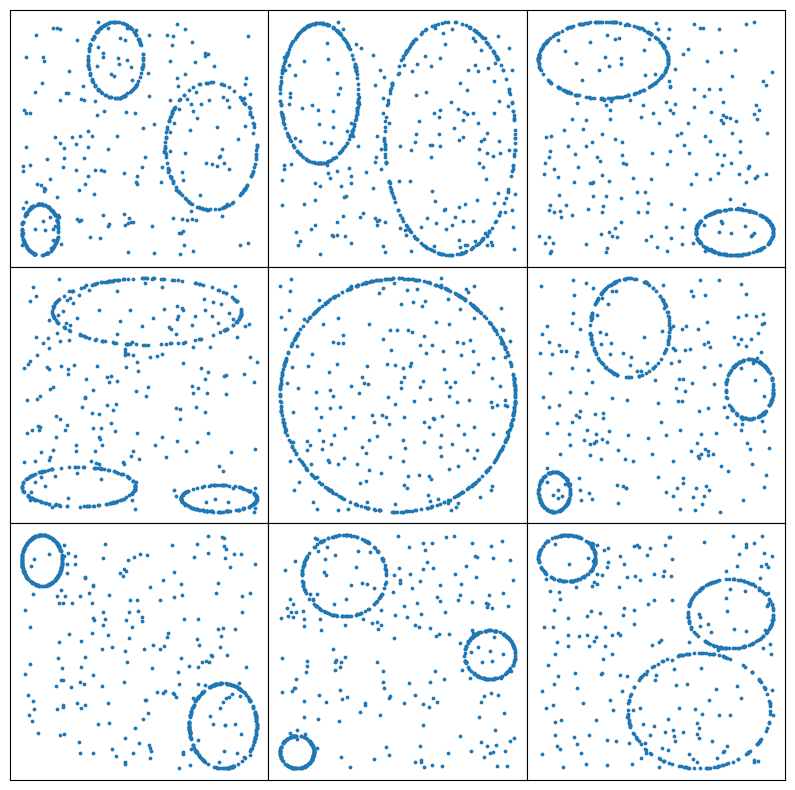

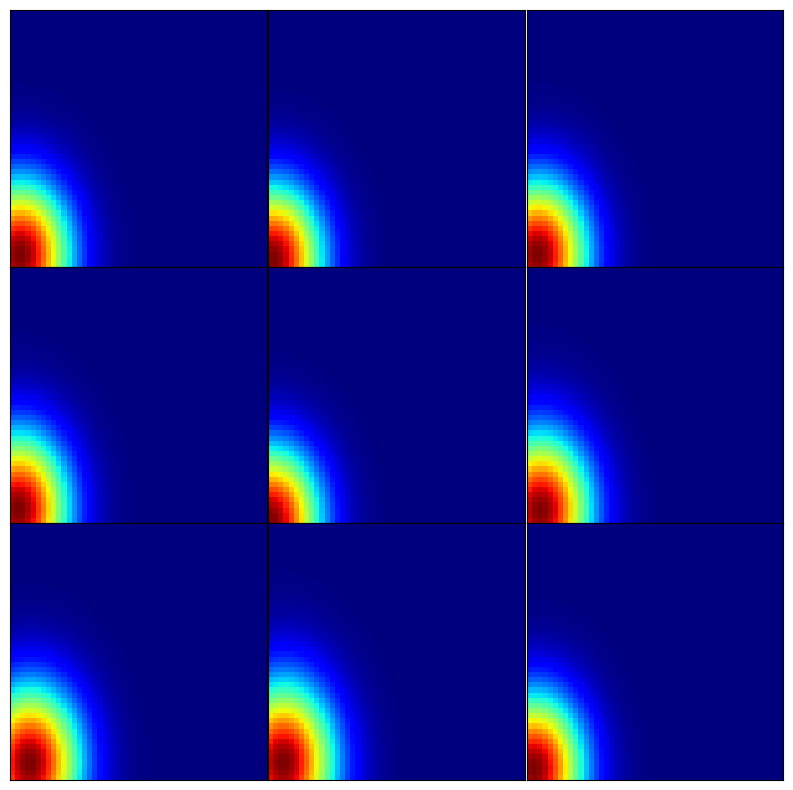

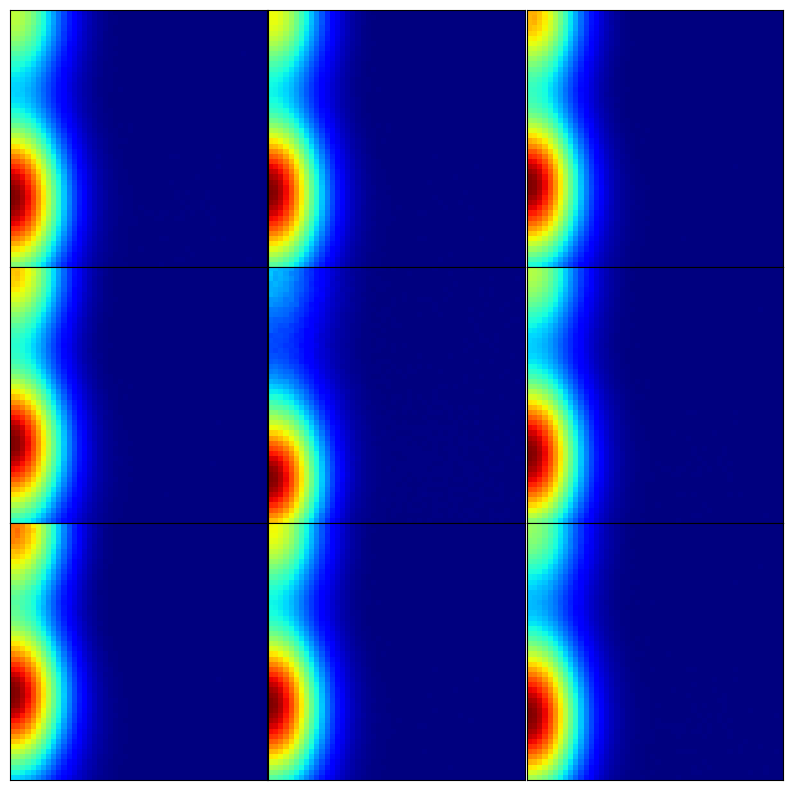

In [ ]:
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.array(x)

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])
        
        try:
            data = to_numpy(tf_noisy_data_test[idx])
            if data.shape[1] != 2:
                print(f"Skipping idx={idx}, unexpected shape: {data.shape}")
                continue
            ax.scatter(data[:, 0], data[:, 1], s=3)
        except Exception as e:
            print(f"Error at idx={idx} in noisy point cloud: {e}")
            continue
        
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig("noisy_gudhi_pc.png", bbox_inches="tight")
print("Saved noisy_gudhi_pc.png")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])
        
        arr = np.array(noisy_PI_test[idx])
        if arr.size != 50*50:
            print(f"Skipping idx={idx}, unexpected size: {arr.size}")
            continue
        
        im = np.flip(arr.reshape(50, 50), 0)  # vertical flip
        ax.imshow(im, cmap="jet")
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig("noisy_gudhi_pi.png", bbox_inches="tight")
print("Saved noisy_gudhi_pi.png")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])
        
        arr = np.array(noisy_PI_prediction[idx])
        if arr.size != 50*50:
            print(f"Skipping idx={idx}, unexpected size: {arr.size}")
            continue
        
        pred = np.flip(arr.reshape(50, 50), 0) 
        ax.imshow(pred, cmap="jet")
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig("noisy_ripsnet_pi.png", bbox_inches="tight")
print("Saved noisy_ripsnet_pi.png")


Yep, even though Gudhi now produces bad images because of the ambiant noise, RipsNet predictions still look rather good. Another way to quantify this is to see the difference between classifiers predicting the number of circles that are trained either from Gudhi or from RipsNet predictions. Let's first see how an XGBoost model performs when using Gudhi descriptors.

In [ ]:
%pip install xgboost
from xgboost import XGBClassifier

Note: you may need to restart the kernel to use updated packages.


In [ ]:
model_classif_gudhi = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_gudhi.fit(PI_train, label_classif_train)
clean_test_acc_gudhi = model_classif_gudhi.score(clean_PI_test, clean_label_classif_test)
noisy_test_acc_gudhi = model_classif_gudhi.score(noisy_PI_test, noisy_label_classif_test)

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:07:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
print("Accuracy on clean test set = " + str(clean_test_acc_gudhi))
print("Accuracy on noisy test set = " + str(noisy_test_acc_gudhi))

Accuracy on clean test set = 1.0
Accuracy on noisy test set = 0.3333333333333333


Well, the classifier definitely does well on clean data but struggles on noisy data. Let's see how another classifier trained on RipsNet descriptors now performs.

In [ ]:
model_classif_RN = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_RN.fit(train_PI_prediction, label_classif_train)
clean_test_acc_RN = model_classif_RN.score(clean_PI_prediction, clean_label_classif_test)
noisy_test_acc_RN = model_classif_RN.score(noisy_PI_prediction, noisy_label_classif_test)

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:07:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
print("Accuracy on clean test set = " + str(clean_test_acc_RN))
print("Accuracy on noisy test set = " + str(noisy_test_acc_RN))

Accuracy on clean test set = 0.6533333333333333
Accuracy on noisy test set = 0.6966666666666667


Well, even though the accuracy is slightly worse on clean data, it does remarkably well when noise is added! This illustrates the robustness of RipsNet-based topological descriptors.

Now, let's play the same game with persistence landscapes, using the same architecture (except for the dimension of the final layer of course). In the three following cells, we define RipsNet, train it on landscapes, and use it to predict persistence landscapes from the data.

In [ ]:
output_dim = PL_train.shape[1] 
model_PL = RaggedPersistenceModel(output_dim=output_dim)

optimizer = Adamax(model_PL.parameters(), lr=5e-4)
criterion = nn.MSELoss()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_PL = model_PL.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adamax(model_PL.parameters(), lr=5e-4)

patience = 200
best_val_loss = float('inf')
patience_counter = 0
num_epochs = 10000

train_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_data_train]
train_targets = torch.tensor(PL_train, dtype=torch.float32).to(device)

val_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_clean_data_test]
val_targets = torch.tensor(clean_PL_test, dtype=torch.float32).to(device)

history = {'train_loss': [], 'val_loss': []}

for epoch in range(num_epochs):
    model_PL.train()
    optimizer.zero_grad()

    outputs = model_PL(train_inputs)
    loss = criterion(outputs, train_targets)
    loss.backward()
    optimizer.step()

    model_PL.eval()
    with torch.no_grad():
        val_outputs = model_PL(val_inputs)
        val_loss = criterion(val_outputs, val_targets)

    history['train_loss'].append(loss.item())
    history['val_loss'].append(val_loss.item())

    if val_loss.item() < best_val_loss - 1e-5:
        best_val_loss = val_loss.item()
        patience_counter = 0
        best_model_state = model_PI.state_dict()
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {loss.item():.6f}, Val loss: {val_loss.item():.6f}")

model_PI.load_state_dict(best_model_state)
print(f"Training complete. Best val_loss = {best_val_loss:.6f}")


/tmp/ipykernel_37538/370936357.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_data_train]
/tmp/ipykernel_37538/370936357.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_targets = torch.tensor(PL_train, dtype=torch.float32).to(device)
/tmp/ipykernel_37538/370936357.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_clean_data_test]
/tmp/ipykernel_37538/370936357.py:15: User

Epoch 50/1000 - Train loss: 0.146623, Val loss: 0.143512
Epoch 100/1000 - Train loss: 0.017933, Val loss: 0.017485
Epoch 150/1000 - Train loss: 0.011534, Val loss: 0.011500
Epoch 200/1000 - Train loss: 0.010692, Val loss: 0.010676
Epoch 250/1000 - Train loss: 0.010356, Val loss: 0.010351
Epoch 300/1000 - Train loss: 0.010146, Val loss: 0.010155
Epoch 350/1000 - Train loss: 0.009863, Val loss: 0.009897
Epoch 400/1000 - Train loss: 0.009330, Val loss: 0.009408
Epoch 450/1000 - Train loss: 0.008447, Val loss: 0.008592
Epoch 500/1000 - Train loss: 0.007297, Val loss: 0.007488
Epoch 550/1000 - Train loss: 0.006328, Val loss: 0.006513
Epoch 600/1000 - Train loss: 0.005745, Val loss: 0.005916
Epoch 650/1000 - Train loss: 0.005255, Val loss: 0.005434
Epoch 700/1000 - Train loss: 0.004752, Val loss: 0.004944
Epoch 750/1000 - Train loss: 0.004189, Val loss: 0.004395
Epoch 800/1000 - Train loss: 0.003542, Val loss: 0.003764
Epoch 850/1000 - Train loss: 0.002880, Val loss: 0.003126
Epoch 900/1000 

In [ ]:
model_PL.eval()

with torch.no_grad():
    train_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_data_train]
    clean_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_clean_data_test]
    noisy_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_noisy_data_test]

    train_PL_prediction = model_PL(train_inputs).cpu().numpy()
    clean_PL_prediction = model_PL(clean_inputs).cpu().numpy()
    noisy_PL_prediction = model_PL(noisy_inputs).cpu().numpy()

print("Predictions computed:")
print(f"train_PI_prediction shape: {train_PL_prediction.shape}")
print(f"clean_PI_prediction shape: {clean_PL_prediction.shape}")
print(f"noisy_PI_prediction shape: {noisy_PL_prediction.shape}")


/tmp/ipykernel_37538/2552692517.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_data_train]
/tmp/ipykernel_37538/2552692517.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clean_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_clean_data_test]
/tmp/ipykernel_37538/2552692517.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_inputs = [torch.tensor(x, dtype=torch.float32).to(device) for x in tf_noisy_data_test]


Predictions computed:
train_PI_prediction shape: (900, 1500)
clean_PI_prediction shape: (300, 1500)
noisy_PI_prediction shape: (300, 1500)


Let's see how good RipsNet is for landscapes now.

Saved clean_gudhi_pc.png
Skipping idx=0, unexpected size: 1500
Skipping idx=1, unexpected size: 1500
Skipping idx=2, unexpected size: 1500
Skipping idx=3, unexpected size: 1500
Skipping idx=4, unexpected size: 1500
Skipping idx=5, unexpected size: 1500
Skipping idx=6, unexpected size: 1500
Skipping idx=7, unexpected size: 1500


/tmp/ipykernel_37538/3741250107.py:38: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  arr = np.array(clean_PL_test[idx])


Skipping idx=8, unexpected size: 1500
Saved clean_gudhi_pl.png
Skipping idx=0, unexpected size: 1500
Skipping idx=1, unexpected size: 1500
Skipping idx=2, unexpected size: 1500
Skipping idx=3, unexpected size: 1500
Skipping idx=4, unexpected size: 1500
Skipping idx=5, unexpected size: 1500
Skipping idx=6, unexpected size: 1500
Skipping idx=7, unexpected size: 1500
Skipping idx=8, unexpected size: 1500
Saved clean_ripsnet_pl.png


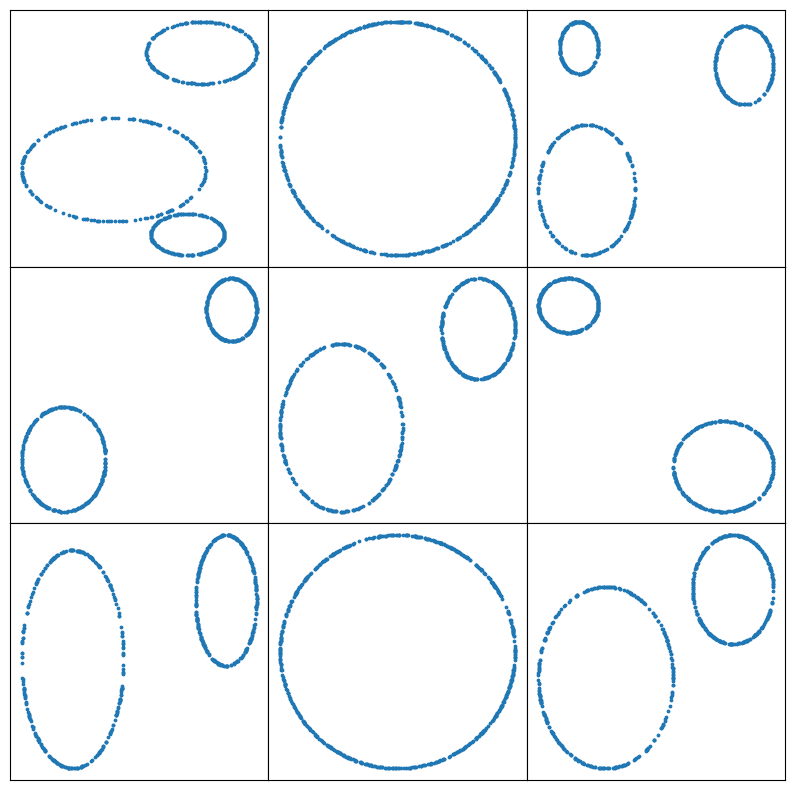

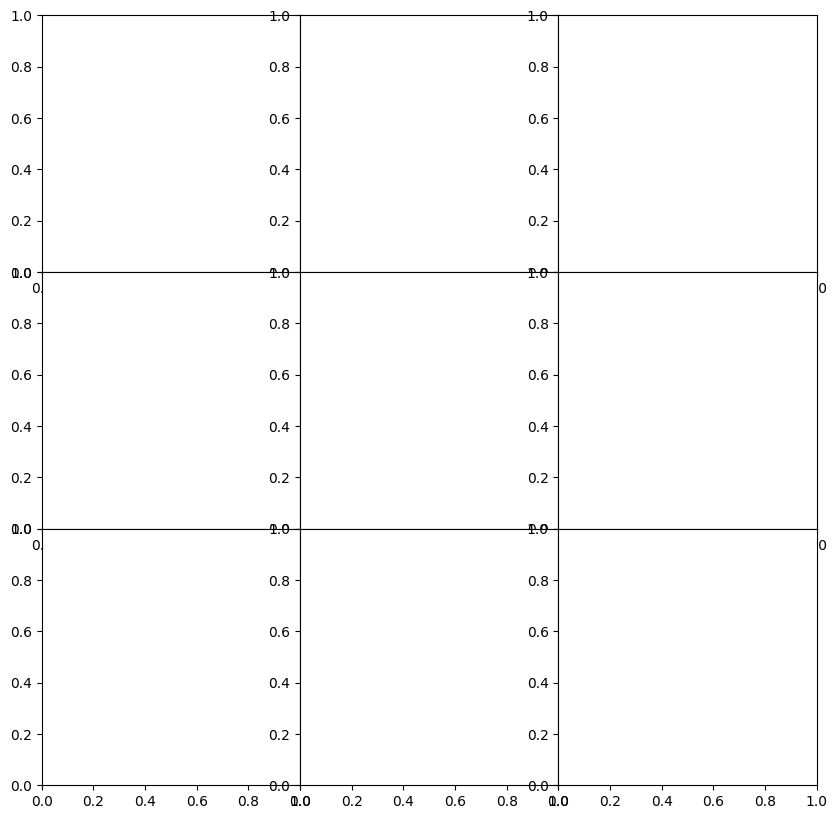

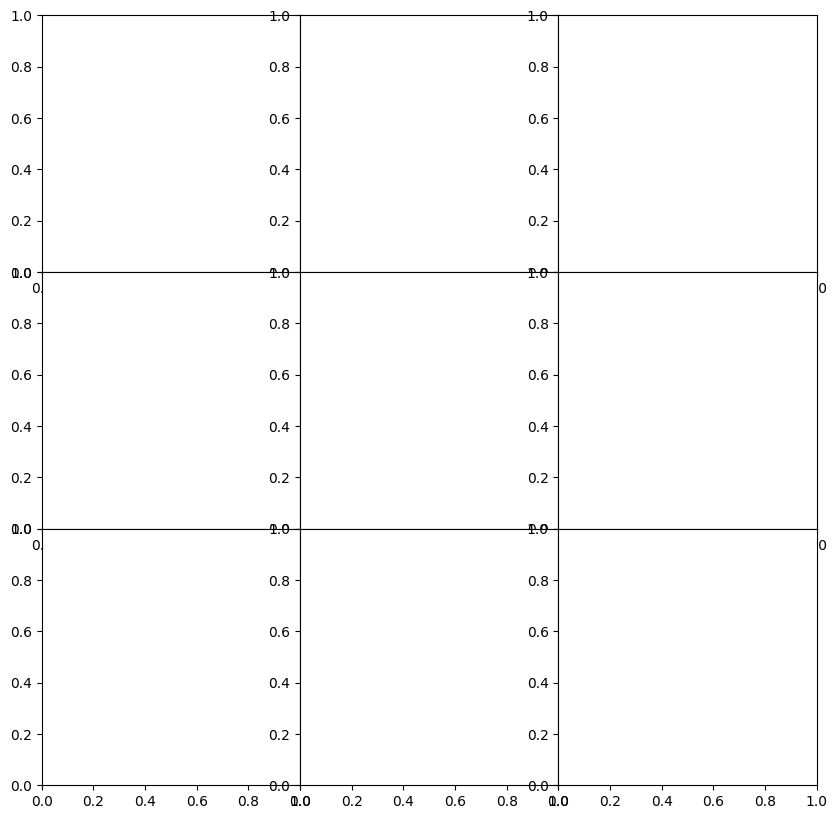

In [ ]:
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.array(x)

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])
        
        try:
            data = to_numpy(tf_clean_data_test[idx])
            if data.shape[1] != 2:
                print(f"Skipping idx={idx}, unexpected shape: {data.shape}")
                continue
            ax.scatter(data[:, 0], data[:, 1], s=3)
        except Exception as e:
            print(f"Error at idx={idx} in point cloud: {e}")
            continue
        
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig('clean_gudhi_pc.png', bbox_inches='tight')
print("Saved clean_gudhi_pc.png")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])
        
        arr = np.array(clean_PL_test[idx])
        if arr.size != 50*50:
            print(f"Skipping idx={idx}, unexpected size: {arr.size}")
            continue
        
        im = np.flip(arr.reshape(50, 50), 0)  # vertical flip
        ax.imshow(im, cmap='jet')
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig('clean_gudhi_pl.png', bbox_inches='tight')
print("Saved clean_gudhi_pl.png")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])
        
        arr = np.array(clean_PL_prediction[idx])
        if arr.size != 50*50:
            print(f"Skipping idx={idx}, unexpected size: {arr.size}")
            continue
        
        pred = np.flip(arr.reshape(50, 50), 0)  
        ax.imshow(pred, cmap='jet')
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig('clean_ripsnet_pl.png', bbox_inches='tight')
print("Saved clean_ripsnet_pl.png")


Saved noisy_gudhi_pc.png
Skipping idx=0, unexpected size: 1500
Skipping idx=1, unexpected size: 1500
Skipping idx=2, unexpected size: 1500
Skipping idx=3, unexpected size: 1500
Skipping idx=4, unexpected size: 1500
Skipping idx=5, unexpected size: 1500
Skipping idx=6, unexpected size: 1500
Skipping idx=7, unexpected size: 1500
Skipping idx=8, unexpected size: 1500


/tmp/ipykernel_37538/3525282999.py:38: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  arr = np.array(noisy_PL_test[idx])


Saved noisy_gudhi_pl.png
Skipping idx=0, unexpected size: 1500
Skipping idx=1, unexpected size: 1500
Skipping idx=2, unexpected size: 1500
Skipping idx=3, unexpected size: 1500
Skipping idx=4, unexpected size: 1500
Skipping idx=5, unexpected size: 1500
Skipping idx=6, unexpected size: 1500
Skipping idx=7, unexpected size: 1500
Skipping idx=8, unexpected size: 1500
Saved noisy_ripsnet_pl.png


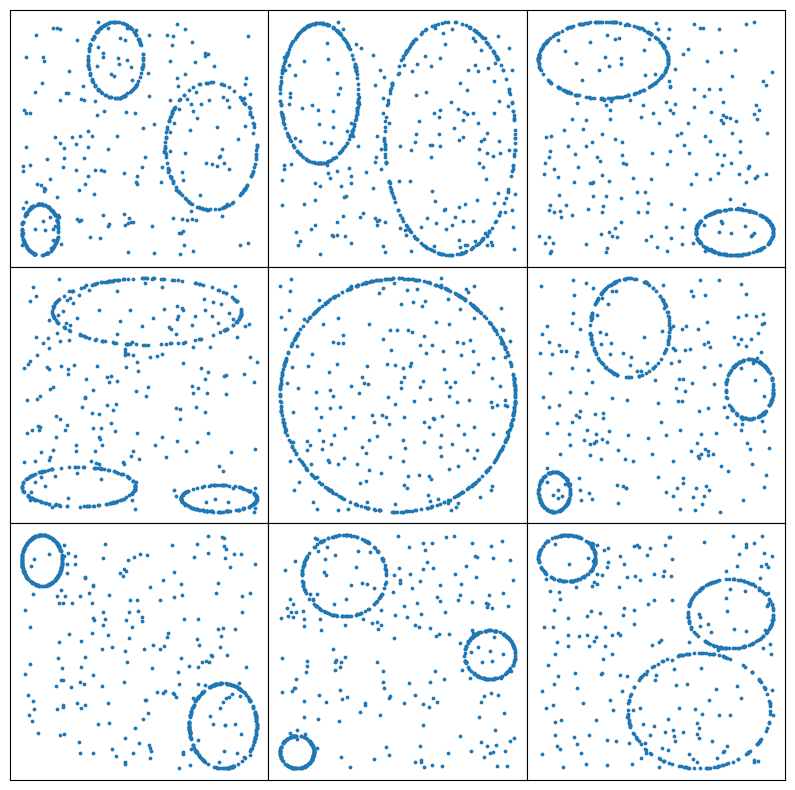

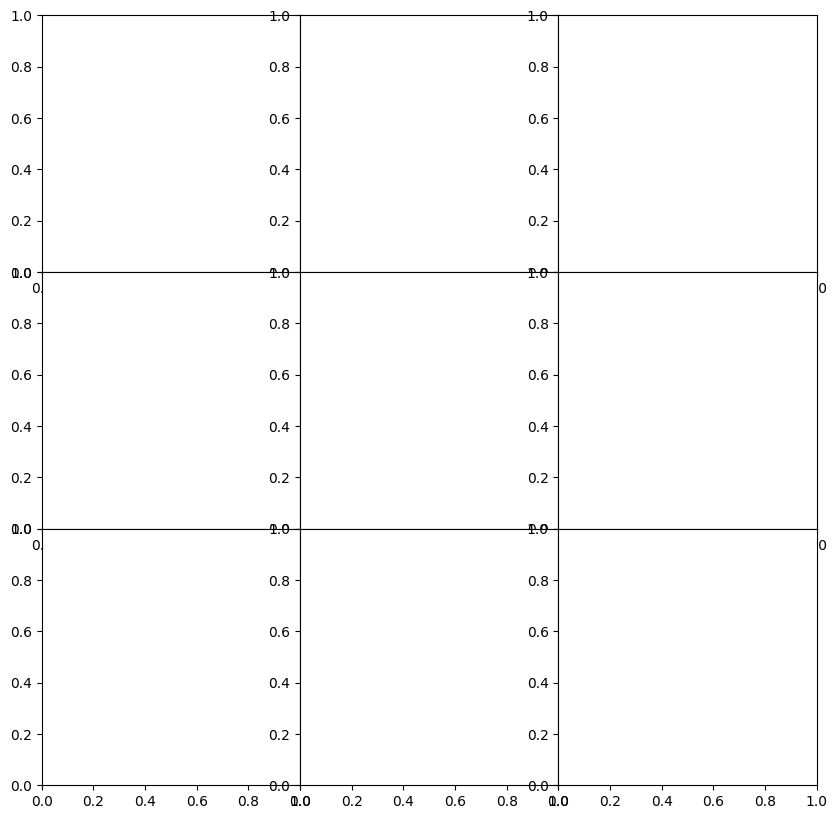

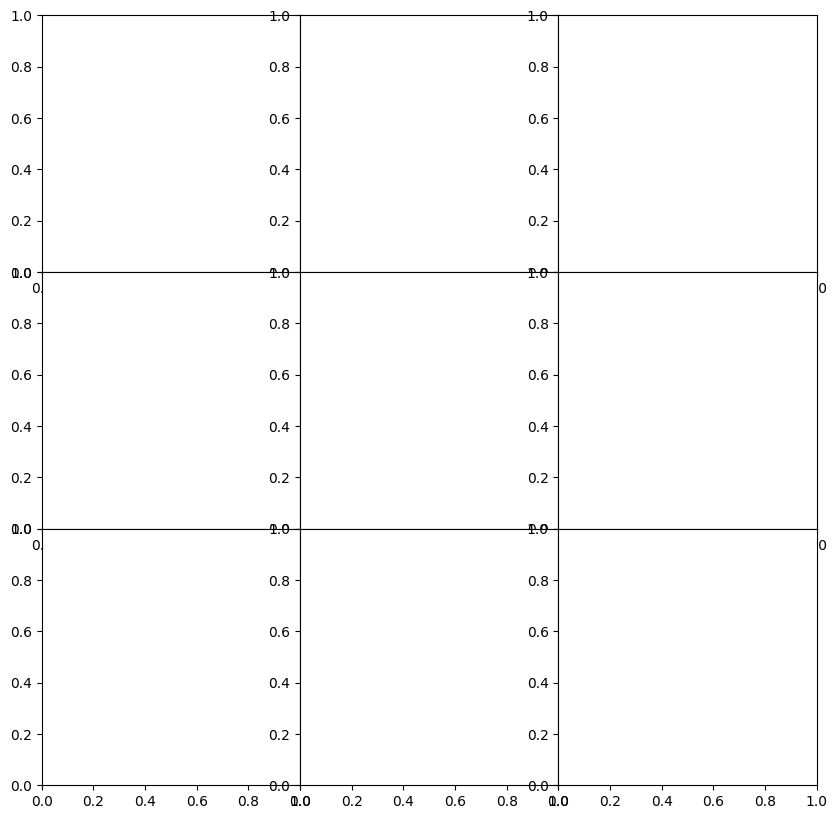

In [ ]:
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.array(x)

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])
        
        try:
            data = to_numpy(tf_noisy_data_test[idx])
            if data.shape[1] != 2:
                print(f"Skipping idx={idx}, unexpected shape: {data.shape}")
                continue
            ax.scatter(data[:, 0], data[:, 1], s=3)
        except Exception as e:
            print(f"Error at idx={idx} in noisy point cloud: {e}")
            continue
        
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig("noisy_gudhi_pc.png", bbox_inches="tight")
print("Saved noisy_gudhi_pc.png")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])
        
        arr = np.array(noisy_PL_test[idx])
        if arr.size != 50*50:
            print(f"Skipping idx={idx}, unexpected size: {arr.size}")
            continue
        
        im = np.flip(arr.reshape(50, 50), 0)  # vertical flip
        ax.imshow(im, cmap="jet")
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig("noisy_gudhi_pl.png", bbox_inches="tight")
print("Saved noisy_gudhi_pl.png")

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

for i in range(3):
    for j in range(3):
        idx = 3 * i + j
        ax = plt.subplot(gs[i, j])
        
        arr = np.array(noisy_PL_prediction[idx])
        if arr.size != 50*50:
            print(f"Skipping idx={idx}, unexpected size: {arr.size}")
            continue
        
        pred = np.flip(arr.reshape(50, 50), 0) 
        ax.imshow(pred, cmap="jet")
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig("noisy_ripsnet_pl.png", bbox_inches="tight")
print("Saved noisy_ripsnet_pl.png")


As before, we end by training XGBoost classifier on both Gudhi and RipsNet generated landscapes.

In [ ]:
model_classif_gudhi = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_gudhi.fit(PL_train, label_classif_train)
clean_test_acc_gudhi = model_classif_gudhi.score(clean_PL_test,  clean_label_classif_test)
noisy_test_acc_gudhi = model_classif_gudhi.score(noisy_PL_test,  noisy_label_classif_test)

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:15:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
print("Accuracy on clean test set = " + str(clean_test_acc_gudhi))
print("Accuracy on noisy test set = " + str(noisy_test_acc_gudhi))

Accuracy on clean test set = 1.0
Accuracy on noisy test set = 0.6666666666666666


In [ ]:
model_classif_RN = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model_classif_RN.fit(train_PL_prediction, label_classif_train)
clean_test_acc_RN = model_classif_RN.score(clean_PL_prediction, clean_label_classif_test)
noisy_test_acc_RN = model_classif_RN.score(noisy_PL_prediction, noisy_label_classif_test)

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:15:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
print("Accuracy on clean test set = " + str(clean_test_acc_RN))
print("Accuracy on noisy test set = " + str(noisy_test_acc_RN))

Accuracy on clean test set = 0.6633333333333333
Accuracy on noisy test set = 0.6866666666666666


The difference is less clear than for persistence images, but present nonetheless! Again, RipsNet exhibits better  robustness properties than Gudhi on noise data, while being faster and almost as good on clean data.